In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pyarrow as pa


In [3]:
df1 = pd.read_feather('HCPFCSchaefer400x17.feather')
df2 = pd.read_csv('unrestricted.csv',sep=';')


/var/folders/sm/hmm_qwmj0rjfxblg2m_hsl6h0000gn/T/ipykernel_41412/3395096080.py:2: DtypeWarning: Columns (181,190,396,397,400,401,403,406,408) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('unrestricted.csv',sep=';')


In [4]:
# Ignore ROI==ROI2
columns_to_drop = df1.columns.str.contains('==')
df1 = df1.loc[:, ~columns_to_drop]

# Calculate average across REST1/LR, REST1/RL, REST2/LR, REST2/RL 
grouped = df1.groupby('subject', as_index=False)
averaged_df1 = grouped.mean()

# Select WM_task in 'unresticted.csv'
df2['Subject'] = df2['Subject'].astype(str)
selected_columns = ['Subject'] + df2.filter(regex = '^WM', axis =1).columns.tolist()
df2_selected = df2[selected_columns]

# Merge them together 
merged_df = pd.merge(averaged_df1, df2_selected, left_on='subject', right_on='Subject')
selected_targets = merged_df.filter(regex = '^WM', axis =1).columns.tolist()

# Clean malformed data 
def clean_number(number_str):
    if isinstance(number_str, str):
        parts = number_str.split('.')
        if len(parts) > 1:
            integer_part = ''.join(parts[:-1])
            decimal_part = parts[-1]
            cleaned_number = integer_part + '.' + decimal_part
        else:
            cleaned_number = number_str
    else:
        cleaned_number = number_str
    
    return cleaned_number

merged_df[selected_targets] = merged_df[selected_targets].applymap(clean_number)

# Remove missing value and non-numeric value in 'merged_df'

for col in selected_targets:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')


merged_df_clean = merged_df.dropna(subset= selected_targets)

# Ouput the merged dataframe
merged_df_clean.to_csv('merged_data_clean_ROI.csv', index=False)

/var/folders/sm/hmm_qwmj0rjfxblg2m_hsl6h0000gn/T/ipykernel_41412/1004677372.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_df1 = grouped.mean()


Mean R2 with PCA: -0.13710838243517293


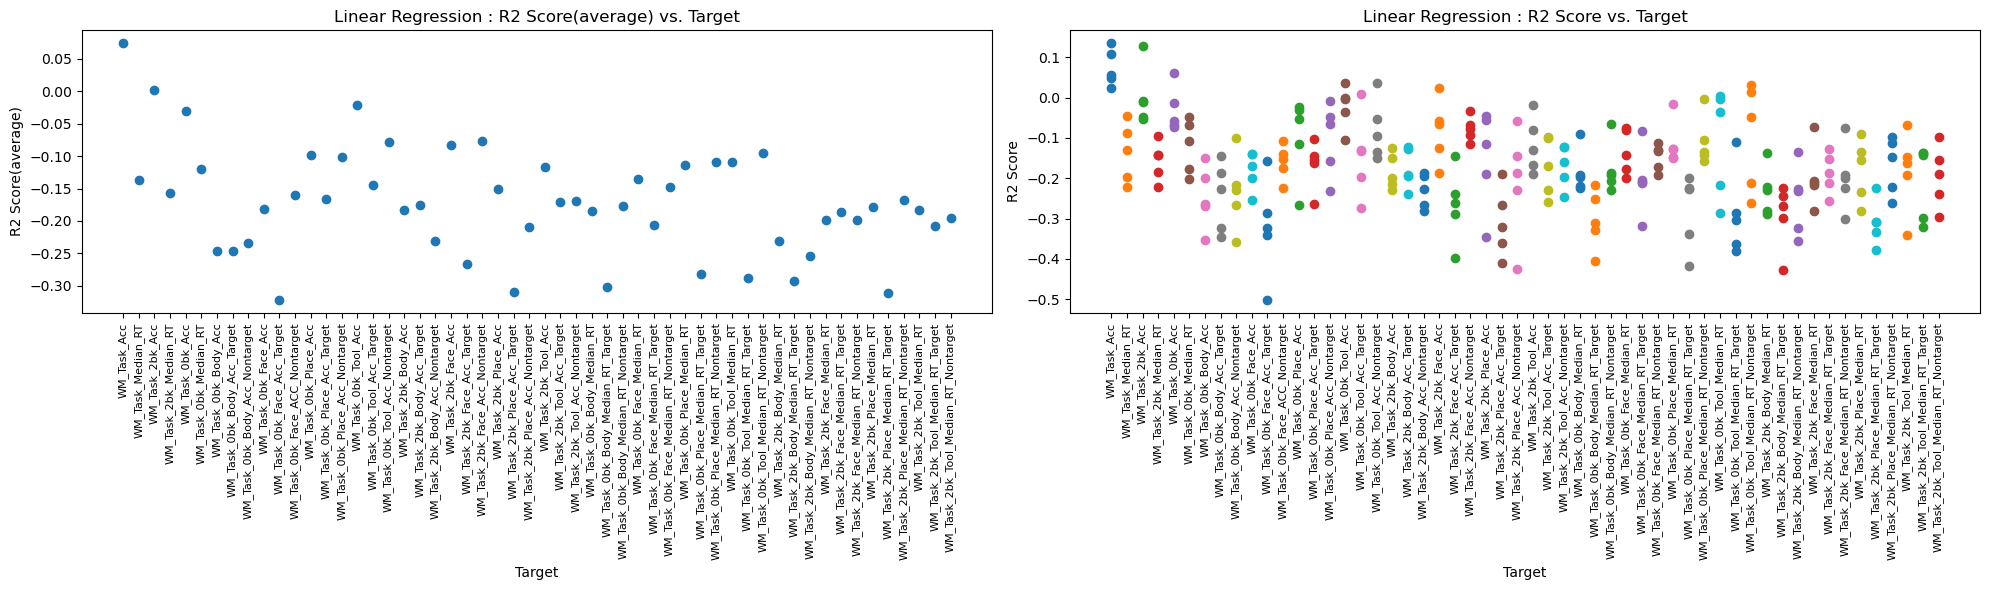

In [5]:
# Step 1: Seperate features (X) and targets (y)

X = merged_df_clean.iloc[:,1:80203]
y = merged_df_clean[selected_targets]

# Step 2: train/test split by 5-fold cross validation
r2_scores_pca = []
r2_scores = []
k = 5
kf = KFold(n_splits = k)

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Step 3: Standardize features (important for regression)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

# Step 4: Train a PCA model for targets
    pca = PCA(n_components = 1)
    y_train_pca = pca.fit_transform(y_train)
    y_test_pca = pca.transform(y_test)

# Step 5: Train a Linear Regression Model for Data with PCA (multiple targets)
    model_pca = LinearRegression()
    model_pca.fit(X_train, y_train_pca)

# Step 5.1: Train a Linear Regression Model for Data without PCA (single target)
    models = []
    for i in range(y_train.shape[1]):
        model = LinearRegression()
        model.fit(X_train,y_train.iloc[:,i])
        models.append(model)

# Step 6: Prediction for data with PCA
    y_pred_pca = model_pca.predict(X_test)

# Step 6.1: Prediction for data wihout PCA
    y_preds = []
    for model in models:
        y_pred = model.predict(X_test) 
        y_preds.append(y_pred)
    
# Step 7: Scoring for data with PCA
    r_squared_pca = r2_score(y_test_pca, y_pred_pca)
    r2_scores_pca.append(r_squared_pca)
       
    #k += 1
    #print("[Fold {0}] R2_score＿pca:{1:.3f}".format(k-6,r_squared))

# Step 7.1: Scoring for data without PCA
    for i, y_pred in enumerate(y_preds):
        r_squared = r2_score(y_test.iloc[:,i], y_pred)
        r2_scores.append(r_squared)

mean_r2_pca = np.mean(r2_scores_pca)
print("Mean R2 with PCA:",mean_r2_pca)

# Scoring Visualization
r2_scores = np.array(r2_scores).reshape(-1,len(selected_targets))
mean_r2 = np.mean(r2_scores,axis=0)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.scatter(selected_targets,mean_r2,marker='o')
plt.xlabel('Target')
plt.ylabel('R2 Score(average)')
plt.title('Linear Regression : R2 Score(average) vs. Target')
plt.xticks(np.arange(len(selected_targets)), selected_targets, rotation='vertical',fontsize=8)


plt.subplot(1, 2, 2)
for i, select_target in enumerate(selected_targets) :
    x_values = np.full(r2_scores.shape[0], selected_targets[i])
    y_values = r2_scores[:,i] 
    plt.scatter(x_values, y_values, marker='o')
plt.xlabel('Target')
plt.ylabel('R2 Score')
plt.title('Linear Regression : R2 Score vs. Target')
plt.xticks(np.arange(len(selected_targets)), selected_targets, rotation='vertical',fontsize=8)


plt.tight_layout()
plt.show()


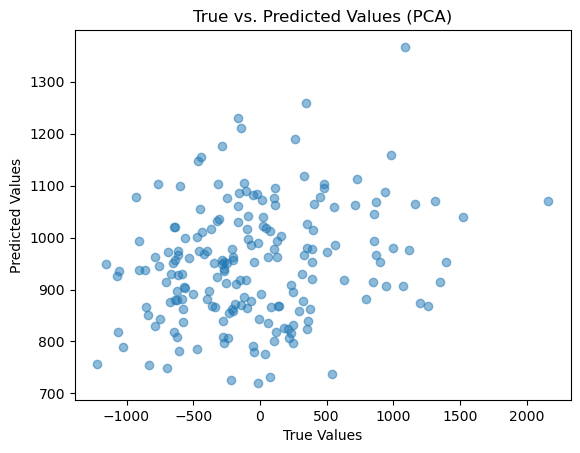

In [7]:
# Visualization
plt.scatter(y_test_pca, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values (PCA)")
plt.show()